# Power Plant Output Prediction

#### [General Information](#cell_1)
#### [Preprocessing](#cell_2)
#### [Training Validation Split](#cell_3)
#### [Basic Model Building](#cell_4)
#### [Visualization](#cell_5)
#### [Feature Selection](#cell_6)
#### [Final Model Building](#cell_7)
#### [Saving Result](#cell_8)
#### [Conclusion](#cell_9)

## <a id="cell_1">General Information</a>

**Informations About Features**

- Temperature (T) in the range 1.81°C and 37.11°C
- Ambient Pressure (AP) in the range 992.89-1033.30 millibar
- Relative Humidity (RH) in the range of 25.56% to 100.16%
- Exhaust Vacuum (V) in the range 25.36-81.56 cm Hg
- Net hourly electrical energy output (PE) 420.26-495.76 MW

**DEPENDENT FEATURE**

**Predict :** PE

In [78]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

## <a id="cell_2">Preprocessing</a>

In [71]:
train_data = pd.read_csv("E:\A\Deep Learning\Machine Learning\ML Dataset\CCPP_participants_Data\Train.csv")

In [74]:
training_data_y = train_data['PE']
training_data_X = train_data.drop('PE', axis=1)

## <a id="cell_3">Training Validation Split</a>

In [72]:
x_train, x_valid, y_train, y_valid = train_test_split(
    training_data_X, training_data_y, test_size=0.1, random_state=42)

In [75]:
indep_scaler = StandardScaler()
x_train = indep_scaler.fit_transform(x_train)
x_valid = indep_scaler.transform(x_valid)

dep_scaler = StandardScaler()
y_train = dep_scaler.fit_transform(y_train.values.reshape(-1,1))
y_valid = dep_scaler.transform(y_valid.values.reshape(-1,1))

## <a id="cell_4">Basic Model Building</a>

In [83]:
# XGBoost
model_1 = XGBRegressor(n_estimators=500, learning_rate=0.05)

model_1.fit(x_train, y_train)
predictions = model_1.predict(x_valid)

error_1 = mean_absolute_error(y_valid, predictions)
error_1

0.12778819344205786

## <a id="cell_5">Visualization</a>

In [79]:
temp_scaler = StandardScaler()
training_data_X_viz = temp_scaler.fit_transform(training_data_X)
training_data_X_viz_df = pd.DataFrame(training_data_X_viz, columns = ['AT', 'V', 'AP', 'RH'])


1. For AT
Skewness: -0.149024
Kurtosis: -1.038187

2. For V
Skewness: 0.177096
Kurtosis: -1.459973

3. For AP
Skewness: 0.240197
Kurtosis: 0.022437

4. For RH
Skewness: -0.423511
Kurtosis: -0.493871


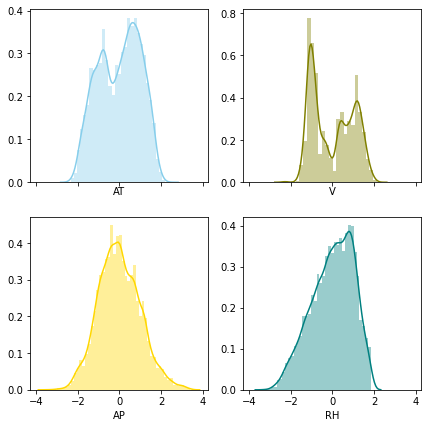

In [80]:
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)

print('\n1. For AT')
sns.distplot( training_data_X_viz_df['AT'] , color="skyblue", ax=axes[0, 0])
print("Skewness: %f" % training_data_X_viz_df['AT'].skew())
print("Kurtosis: %f" % training_data_X_viz_df['AT'].kurt())

print('\n2. For V')
sns.distplot( training_data_X_viz_df['V'] , color="olive", ax=axes[0, 1])
print("Skewness: %f" % training_data_X_viz_df['V'].skew())
print("Kurtosis: %f" % training_data_X_viz_df['V'].kurt())

print("\n3. For AP")
sns.distplot( training_data_X_viz_df['AP'] , color="gold", ax=axes[1, 0])
print("Skewness: %f" % training_data_X_viz_df['AP'].skew())
print("Kurtosis: %f" % training_data_X_viz_df['AP'].kurt())

print('\n4. For RH')
sns.distplot( training_data_X_viz_df['RH'] , color="teal", ax=axes[1, 1])
print("Skewness: %f" % training_data_X_viz_df['RH'].skew())
print("Kurtosis: %f" % training_data_X_viz_df['RH'].kurt())

Well, the graphs are pretty good and well distributed! As the skewnesses are in the considerable range, thus we will not going for the transformations!

## <a id="cell_6">Feature Selection</a>

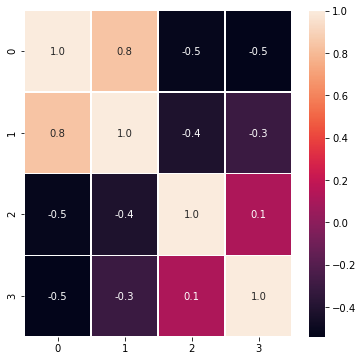

In [81]:
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(pd.DataFrame(x_train).corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

It seems **AT** and **V** are related to each other closely!

From the dist-plot we can see that **V** is been distributed in an ugly manner than **AT**

So, let us remove **V**

I have calculate the error after selecting the features, but that error are more than the previous model!

**As these are giving more error, thus I decide to do hyper-parameter tuning on previous model!**

## <a id="cell_7">Final Model Building</a>

### Pre-processing

In [82]:
test_X = pd.read_csv("E:\A\Deep Learning\Machine Learning\ML Dataset\CCPP_participants_Data\Test.csv")

test_X = temp_scaler.transform(test_X)

dep_scaler_final = StandardScaler()
training_data_y = dep_scaler_final.fit_transform(training_data_y.values.reshape(-1,1))

In [84]:
# XGBoost
model_2 = XGBRegressor(n_estimators=3000, learning_rate=0.1)

model_2.fit(training_data_X_viz_df, training_data_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=3000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Making Predictions

In [86]:
predictions = model_2.predict(pd.DataFrame(test_X, columns = ['AT', 'V', 'AP', 'RH']))
final = dep_scaler_final.inverse_transform(predictions)
final_df = pd.DataFrame(final, columns=['PE'])

## <a id="cell_8">Saving Result</a>

In [87]:
final_df.to_csv('my_submission.csv', index=False)

## <a id="cell_9">Conclusion</a>

I have also implement the problem in Deep Learning network more specifically that was just a shallow network, and then I compare the **RMSE** of the final output, so it says the machine learning model was better than current one. 

As it was a Hackathon project, it also had a time limit for submission, so I was unable to fine tuning the deep learning model and submit the machine learning project! Which gave me a score of **2.2722068544013796** & the model gave me a AIR of **30**, it certainly boost my eagerness.